<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling_ANN%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [3]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 122)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,iterm,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,mchno_etymd_8_norm_count,acqic_stocn_nunique,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,...,acqic_iterm_3_norm_count,acqic_hcefg_7_norm_count,mchno_ovrlt_nunique,mchno_etymd_nunique,acqic_hcefg_8_norm_count,bacno_scity_nunique,mchno_stocn_nunique,acqic_hcefg_1_norm_count,mchno_etymd_7_norm_count,acqic_hcefg_5_norm_count,bacno_etymd_4_norm_count,cano_mchno_nunique,acqic_etymd_10_norm_count,acqic_etymd_7_norm_count,mchno_etymd_0_norm_count,cano_etymd_0_norm_count,acqic_etymd_0_norm_count,cano_etymd_2_norm_count,mchno_iterm_nunique,mchno_hcefg_5_norm_count,cano_iterm_nunique,acqic_hcefg_2_norm_count,mchno_hcefg_1_norm_count,mchno_contp_6_norm_count,cano_scity_nunique,cano_contp_nunique,mchno_contp_2_norm_count,cano_contp_2_norm_count,mchno_contp_5_norm_count,cano_hcefg_nunique,bacno_etymd_0_norm_count,cano_mcc_nunique,acqic_hcefg_0_norm_count,bacno_acqic_nunique,mchno_iterm_0_norm_count,mchno_hcefg_0_norm_count,cano_hcefg_5_norm_count,cano_etymd_6_norm_count,txkey,fraud_ind
0,0,0,102,6862,0,61954,0,5,5,16158,0,0,0,0,0,59034,37846,457,0,112785,0.001044,0.998956,0.001344,0.998656,0.0,1.0,1,2,0.0,1.0,1,0.000000,0.000000,1,3,1,0.987376,0.012624,0.000000,30627,...,0.000000,0.0,2,1,0.000000,13,1,0.000000,0.0,0.983448,0.125000,33,0.0,0.0,1.000000,0.212500,1.000000,0.362500,1,0.989928,1,0.000000,0.000000,0.000000,13,3,0.0,0.012500,1.000000,2,0.212500,21,0.009383,18,1.000000,0.000728,0.987500,0.0,516056,0
1,0,0,102,0,2,38216,5795,0,5,13693,0,0,0,0,0,0,45476,451,0,133951,0.000016,0.997536,0.000000,0.994768,0.0,1.0,2,7,0.0,1.0,1,0.000000,0.000188,2,6,1,0.991720,0.008280,0.000000,19252,...,0.000000,0.0,2,7,0.003276,4,2,0.042083,0.0,0.006682,0.391304,11,0.0,0.0,0.024906,0.043478,0.008377,0.434783,1,0.034542,2,0.013267,0.039878,0.000000,4,1,0.0,0.000000,0.968283,2,0.043478,8,0.931187,7,1.000000,0.911000,0.652174,0.0,4376,0
2,0,0,102,6862,0,54640,0,5,5,16158,0,0,0,0,0,59034,187354,457,0,15350,0.001044,0.998956,0.001344,0.998656,0.0,1.0,1,2,0.0,1.0,1,0.000000,0.000000,1,3,1,0.987376,0.012624,0.000000,30627,...,0.000000,0.0,2,1,0.000000,4,1,0.000000,0.0,0.983448,0.333333,12,0.0,0.0,1.000000,0.222222,1.000000,0.055556,1,0.989928,1,0.000000,0.000000,0.000000,4,1,0.0,0.000000,1.000000,2,0.222222,7,0.009383,7,1.000000,0.000728,0.944444,0.0,483434,0
3,0,0,102,6697,5,62128,3267,5,5,40413,0,0,0,0,62,50185,29812,247,0,156492,0.000000,1.000000,0.000149,0.999643,0.0,1.0,101,2,0.0,1.0,1,0.142619,0.000000,1,9,1,0.988238,0.011762,0.312315,74622,...,0.002037,0.0,2,5,0.003765,9,1,0.024410,0.0,0.965999,0.378378,25,0.0,0.0,0.000000,0.000000,0.000000,0.245614,5,0.984111,2,0.001563,0.012910,0.010924,7,2,0.0,0.035088,0.989076,1,0.000000,12,0.000004,8,0.861966,0.000000,1.000000,0.0,1407164,0
4,0,0,102,5959,4,65231,5795,5,5,25962,0,0,0,0,62,93290,80881,263,0,105534,0.000000,1.000000,0.000038,0.999894,0.0,1.0,34,2,0.0,1.0,1,0.077908,0.000000,1,7,1,0.990016,0.009984,0.206081,41913,...,0.000000,0.0,1,1,0.000857,8,1,0.009496,0.0,0.982903,0.089744,28,0.0,0.0,0.000000,0.365079,0.000000,0.079365,1,1.000000,1,0.000707,0.000000,0.000000,8,3,0.0,0.079365,1.000000,2,0.384615,16,0.000000,11,1.000000,0.000000,0.984127,0.0,1051004,0


# test

In [4]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 121)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,iterm,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,mchno_etymd_8_norm_count,acqic_stocn_nunique,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,...,cano_etymd_4_norm_count,acqic_iterm_3_norm_count,acqic_hcefg_7_norm_count,mchno_ovrlt_nunique,mchno_etymd_nunique,acqic_hcefg_8_norm_count,bacno_scity_nunique,mchno_stocn_nunique,acqic_hcefg_1_norm_count,mchno_etymd_7_norm_count,acqic_hcefg_5_norm_count,bacno_etymd_4_norm_count,cano_mchno_nunique,acqic_etymd_10_norm_count,acqic_etymd_7_norm_count,mchno_etymd_0_norm_count,cano_etymd_0_norm_count,acqic_etymd_0_norm_count,cano_etymd_2_norm_count,mchno_iterm_nunique,mchno_hcefg_5_norm_count,cano_iterm_nunique,acqic_hcefg_2_norm_count,mchno_hcefg_1_norm_count,mchno_contp_6_norm_count,cano_scity_nunique,cano_contp_nunique,mchno_contp_2_norm_count,cano_contp_2_norm_count,mchno_contp_5_norm_count,cano_hcefg_nunique,bacno_etymd_0_norm_count,cano_mcc_nunique,acqic_hcefg_0_norm_count,bacno_acqic_nunique,mchno_iterm_0_norm_count,mchno_hcefg_0_norm_count,cano_hcefg_5_norm_count,cano_etymd_6_norm_count,txkey
1521787,0,0,102,6862,0,77950,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,...,0.0,0.0,0.0,2,1,0.0,1,1,0.0,0.0,0.983448,0.0,1,0.0,0.0,1.0,1.0,1.0,0.0,1,0.989191,1,0.0,0.0,0.0,1,1,0.0,0.0,1.0,1,1.0,1,0.009383,1,1.0,0.000193,1.0,0.0,592489
1521788,0,0,102,6862,0,79549,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,...,0.0,0.0,0.0,2,1,0.0,1,1,0.0,0.0,0.983448,0.0,1,0.0,0.0,1.0,1.0,1.0,0.0,1,0.989191,1,0.0,0.0,0.0,1,1,0.0,0.0,1.0,1,1.0,1,0.009383,1,1.0,0.000193,1.0,0.0,592452
1521789,0,0,102,6862,0,60355,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,...,0.0,0.0,0.0,2,1,0.0,1,1,0.0,0.0,0.983448,0.0,1,0.0,0.0,1.0,1.0,1.0,0.0,1,0.989191,1,0.0,0.0,0.0,1,1,0.0,0.0,1.0,1,1.0,1,0.009383,1,1.0,0.000193,1.0,0.0,590212
1521790,0,0,102,6862,0,60296,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,...,0.0,0.0,0.0,2,1,0.0,1,1,0.0,0.0,0.983448,0.0,1,0.0,0.0,1.0,1.0,1.0,0.0,1,0.989191,1,0.0,0.0,0.0,1,1,0.0,0.0,1.0,1,1.0,1,0.009383,1,1.0,0.000193,1.0,0.0,590209
1521791,0,0,102,6862,0,77933,0,5,5,16158,0,0,0,0,0,59060,116168,457,0,162489,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,...,0.0,0.0,0.0,2,1,0.0,1,1,0.0,0.0,0.983448,0.0,1,0.0,0.0,1.0,1.0,1.0,0.0,1,0.989191,1,0.0,0.0,0.0,1,1,0.0,0.0,1.0,1,1.0,1,0.009383,1,1.0,0.000193,1.0,0.0,592488


# 定義 features & num_features & target

In [5]:
# 全部特徵
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       ],axis=1).columns.tolist()

# 新特徵才是num_features
num_features = sorted(list(set(features)^set(中文map.keys())))
num_features.remove('fraud_ind')
num_features.remove('locdt')
num_features.remove('txkey')

#只用num_features
features = num_features

y_name = 'fraud_ind'

print(len(features),features)
print(len(num_features),num_features)
print(len([y_name]),[y_name])

100 ['acqic_bacno_nunique', 'acqic_cano_nunique', 'acqic_contp_2_norm_count', 'acqic_contp_5_norm_count', 'acqic_contp_6_norm_count', 'acqic_contp_nunique', 'acqic_csmcu_nunique', 'acqic_etymd_0_norm_count', 'acqic_etymd_10_norm_count', 'acqic_etymd_2_norm_count', 'acqic_etymd_4_norm_count', 'acqic_etymd_5_norm_count', 'acqic_etymd_6_norm_count', 'acqic_etymd_7_norm_count', 'acqic_etymd_8_norm_count', 'acqic_etymd_nunique', 'acqic_hcefg_0_norm_count', 'acqic_hcefg_1_norm_count', 'acqic_hcefg_2_norm_count', 'acqic_hcefg_5_norm_count', 'acqic_hcefg_7_norm_count', 'acqic_hcefg_8_norm_count', 'acqic_hcefg_9_norm_count', 'acqic_hcefg_nunique', 'acqic_iterm_0_norm_count', 'acqic_iterm_1_norm_count', 'acqic_iterm_2_norm_count', 'acqic_iterm_3_norm_count', 'acqic_iterm_4_norm_count', 'acqic_iterm_5_norm_count', 'acqic_iterm_6_norm_count', 'acqic_iterm_7_norm_count', 'acqic_iterm_8_norm_count', 'acqic_iterm_nunique', 'acqic_mcc_nunique', 'acqic_mchno_nunique', 'acqic_ovrlt_0_norm_count', 'acqic

# both / test

In [6]:
f = {}
for col in num_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res.tail()

,both/test
bacno_stscd_2_norm_count,0.878689
bacno_stscd_0_norm_count,0.873786
cano_stscd_0_norm_count,0.851240
bacno_cano_nunique,0.846154
cano_stscd_2_norm_count,0.843882


# 切分 train 跟 val_1 , val_2

In [7]:
from sklearn.model_selection import train_test_split
train ,val = train_test_split(train[features+[y_name]] ,test_size=0.25 ,random_state=42)
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.50 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1141340, 101)
(190223, 101)
(190224, 101)


# scaler

In [0]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
val_1[features] = scaler.transform(val_1[features])
val_2[features] = scaler.transform(val_2[features])
test[features] = scaler.transform(test[features])

# 建立ANN模型

評價函數

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


# optimizers

In [0]:
from keras import optimizers
adam = keras.optimizers.Adam(lr=0.001/2)#除2

In [10]:
from keras import backend
from keras.layers import Dropout,Dense,Flatten
from keras.models import Sequential
import math

model = Sequential()
num_unit = 128
num_layers = 5
out_dim = 1
input_dim = 100

#輸入層
model.add(Dense(num_unit,
                activation = 'relu',
                input_dim = input_dim))

#隱藏層
for i in range(num_layers-1):
  model.add(Dense(num_unit,
                  activation = 'relu'))

#輸出層
model.add(Dense(out_dim,
                activation = 'sigmoid'))

#編譯
model.compile(optimizer = adam,
              loss = 'binary_crossentropy',
              metrics=[f1_m])
model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 79,105


# Model Fit

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=40,
                   mode='min',
                   restore_best_weights=True)

In [12]:
history = model.fit( train[features] ,train[y_name],
                    epochs = 300,
                    batch_size = train.shape[0],
                    validation_data = (val_1[features],val_1[y_name]),
                    callbacks = [es])




Train on 1141340 samples, validate on 190223 samples
Epoch 1/300





1141340/1141340 [==============================] - 9s 8us/step - loss: 0.8202 - f1_m: 0.0270 - val_loss: 0.6404 - val_f1_m: 0.0160
Epoch 2/300
1141340/1141340 [==============================] - 4s 4us/step - loss: 0.6403 - f1_m: 0.0159 - val_loss: 0.5151 - val_f1_m: 0.0000e+00
Epoch 3/300
1141340/1141340 [==============================] - 4s 3us/step - loss: 0.5147 - f1_m: 0.0000e+00 - val_loss: 0.4170 - val_f1_m: 0.0000e+00
Epoch 4/300
1141340/1141340 [==============================] - 4s 3us/step - loss: 0.4165 - f1_m: 0.0000e+00 - val_loss: 0.3308 - val_f1_m: 0.0000e+00
Epoch 5/300
1141340/1141340 [==============================] - 4s 3us/step - loss: 0.3302 - f1_m: 0.0000e+00 - val_loss: 0.2541 - val_f1_m: 0.0000e+00
Epoch 6/300
1141340/1141340 [==============================] - 4s 3us/step - loss: 0.2534 - f1_m: 0.0000e+00 - val_loss: 0.1903 - val_f1_m: 0.0000e+00
Epoch 7/300
1141340/1141340 [================

# 訓練過程評估

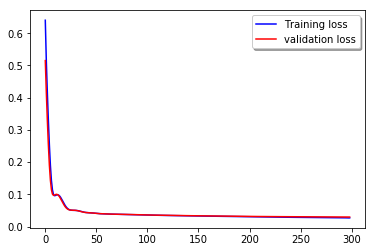

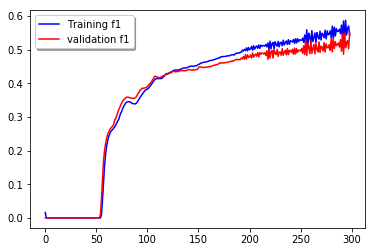

In [14]:
import matplotlib.pyplot as plt

n=1

fig, ax = plt.subplots(1,1)
ax.plot(history.history['loss'][n:], color='b', label="Training loss")
ax.plot(history.history['val_loss'][n:], color='r', label="validation loss")
legend = ax.legend(loc='best', shadow=True)
plt.show()

fig, ax = plt.subplots(1,1)
ax.plot(history.history['f1_m'][n:], color='b', label="Training f1")
ax.plot(history.history['val_f1_m'][n:], color='r', label="validation f1")
legend = ax.legend(loc='best', shadow=True)
plt.show()

# val_2's F1 report

In [15]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features]).ravel()).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    187682
           1       0.69      0.45      0.54      2542

    accuracy                           0.99    190224
   macro avg       0.84      0.72      0.77    190224
weighted avg       0.99      0.99      0.99    190224



# 產生submission

In [16]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":pd.Series(model.predict(test[features]).ravel()).apply(round).values})

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    417178
1      4487
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [17]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.33816,1.33527,1.33632,1.06411


# 保存預測結果

In [0]:
submission.to_csv("./submission_34.csv")

In [19]:
print(submission["fraud_ind"].value_counts())

0    417178
1      4487
Name: fraud_ind, dtype: int64
